[link text](https://)

# WEATHER IMAGE CLASSIFICATION



In [ ]:
%tensorflow_version 1.x

import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator


print("Tensorflow version %s" %tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow 1.x selected.


Using TensorFlow backend.


Tensorflow version 1.15.2
Found GPU at: /device:GPU:0


## Loading MWI dataset


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

datadir = '/content/drive/My Drive/datasets/MWI-Dataset-1.1_2000'

batch_size = 64
target_size = (227,227)

datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.1,\
    rotation_range=10,\
    width_shift_range=0.1,\
    height_shift_range=0.1,\
    horizontal_flip=True,\
    vertical_flip=False,
    validation_split = 0.2)

train_generator = datagen.flow_from_directory(
    directory=datadir,
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    subset = 'training'
)

test_generator = datagen.flow_from_directory(
    directory=datadir,
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    subset ='validation'
)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Image input (227, 227, 3)
Classes: ['HAZE', 'RAINY', 'SNOWY', 'SUNNY']
Loaded 1600 training samples from 4 classes.
Loaded 400 test samples from 4 classes.


## Show random image



RAINY


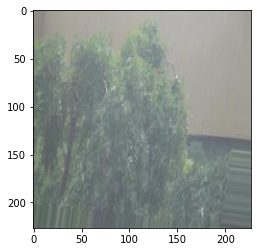

RAINY


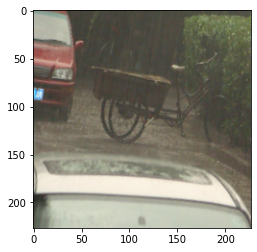

RAINY


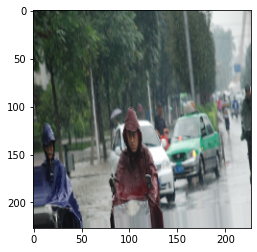

In [ ]:
import matplotlib.pyplot as plt

n = 3
train_generator.reset()
x,y = train_generator.next()
# x,y size is train_generator.batch_size

for i in range(0,n):
    image = x[i]
    label = y[i].argmax()  # categorical from one-hot-encoding
    print(classnames[label])
    plt.imshow(image)
    plt.show()


##Transfer Learning

In [ ]:
from keras import applications
from keras.models import Model, Input

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,\
                         UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers


def load_backbone_net(input_shape):
    
    # define input tensor
    input0 = Input(shape=input_shape)

    # load a pretrained model on imagenet without the final dense layer
    feature_extractor = applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=input0)
    
    
    feature_extractor = feature_extractor.output
    feature_extractor = Model(input=input0, output=feature_extractor)
    optimizer = 'adam' #alternative 'SGD'

    feature_extractor.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

    return feature_extractor


def transferNet(feature_extractor, num_classes, output_layer_name, trainable_layers):
    
    # get the original input layer tensor
    input_t = feature_extractor.get_layer(index=0).input

    # set the feture extractor layers as non-trainable
    for idx,layer in enumerate(feature_extractor.layers):
      if layer.name in trainable_layers:
        layer.trainable = True
      else:
        layer.trainable = False

    # get the output tensor from a layer of the feature extractor
    output_extractor = feature_extractor.get_layer(name = output_layer_name).output
    
    #output_extractor = MaxPooling2D(pool_size=(4,4))(output_extractor)

    # flat the output of a Conv layer
    flatten = Flatten()(output_extractor) 
    flatten_norm = BatchNormalization()(flatten)

    # add a Dense layer
    dense = Dropout(0.5)(flatten_norm)
    dense = Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.4))(dense)
    dense = BatchNormalization()(dense)
    

    # add a Dense layer
    dense = Dropout(0.5)(dense)
    dense = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.4))(dense)
    dense = BatchNormalization()(dense)

    # add the final output layer
    dense = BatchNormalization()(dense)
    dense = Dense(num_classes, activation='softmax')(dense)
    

    model = Model(input=input_t, output=dense, name="transferNet")
    
    optimizer = 'adam' #alternative 'SGD'
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

    return model

# load the pre-trained model
feature_extractor = load_backbone_net(input_shape)
feature_extractor.summary()


# choose the layer from which you can get the features (block5_pool the end, glob_pooling to get the pooled version of the output)
name_output_extractor = "block5_pool"
trainable_layers = ["block5_conv3"]

# build the transfer model
transfer_model = transferNet(feature_extractor, num_classes, name_output_extractor, trainable_layers)
transfer_model.summary()

In [ ]:
import os
from keras.models import load_model

models_dir = '/content/drive/My Drive/models'

def loadmodel(problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    try:
        model = load_model(filename)
        print("\nModel loaded successfully from file %s\n" %filename)
    except OSError:    
        print("\nModel file %s not found!!!\n" %filename)
        model = None
    return model

transfer_model = loadmodel('TransferMugnanoNet_2000_227x227_MWI')


import pickle
metrics_hists = pickle.load( open( '/content/drive/My Drive/models/HIST_TransferMugnanoNet_2000_227x227_MWI.dat', "rb" ) )
 

In [ ]:
steps_per_epoch = train_generator.n//train_generator.batch_size
val_steps = test_generator.n//test_generator.batch_size+1

print(steps_per_epoch)
print(val_steps)

25
7


In [ ]:
# fit the transferNet on the training data
from keras import callbacks
stopping = callbacks.EarlyStopping(monitor='val_acc', patience=3)
train_generator.reset()
test_generator.reset()
try:
    #history_transfer = transfer_model.fit_generator(train_generator, epochs=20, verbose=1, callbacks=[stopping],\
    history_transfer = transfer_model.fit_generator(train_generator, epochs=15, verbose=1,\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass


Save the model

In [ ]:
import os

models_dir = '/content/drive/My Drive/models'

def savemodel(model,problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    transfer_model.save(filename)
    print("\nModel saved successfully on file %s\n" %filename)

# Save the model
savemodel(transfer_model,'TransferMugnanoNet_2000_227x227_MWI')



import pickle 
metrics_hists = history_transfer.history
pickle.dump( metrics_hists, open('/content/drive/My Drive/models/HIST_TransferMugnanoNet_2000_227x227_MWI.dat', 'wb' ) )


Model saved successfully on file /content/drive/My Drive/models/TransferMugnanoNet_2000_227x227_MWI.h5



## Print scores


In [ ]:
#Accuracy
val_steps=test_generator.n//test_generator.batch_size+1
loss, acc = transfer_model.evaluate_generator(test_generator,verbose=1,steps=val_steps)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)

5/7 [====================>.........] - ETA: 3s

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


7/7 [==============================] - 10s 1s/step
Test loss: 2.833536
Test accuracy: 0.827500


In [ ]:
#Precision and Recall
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

val_steps=test_generator.n//test_generator.batch_size+1

test_generator.reset()
preds = transfer_model.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))


  

Confusion matrix analysis

In [ ]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

val_steps=test_generator.n//test_generator.batch_size+1

test_generator.reset()

# predictions from transferNet
preds = transfer_model.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

cm = confusion_matrix(Ytest, Ypred)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))
  

5/7 [====================>.........] - ETA: 2s

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


7/7 [==============================] - 8s 1s/step
True                 Predicted         	errors 	err % 
------------------------------------------------------------------
SNOWY            ->  RAINY             	23 	5.75 % 
HAZE             ->  SNOWY             	12 	3.00 % 
HAZE             ->  RAINY             	11 	2.75 % 
RAINY            ->  SNOWY             	9 	2.25 % 
HAZE             ->  SUNNY             	7 	1.75 % 
SUNNY            ->  SNOWY             	4 	1.00 % 
SUNNY            ->  RAINY             	2 	0.50 % 
RAINY            ->  SUNNY             	1 	0.25 % 
SNOWY            ->  HAZE              	1 	0.25 % 
SNOWY            ->  SUNNY             	1 	0.25 % 
SUNNY            ->  HAZE              	1 	0.25 % 


##Plot results

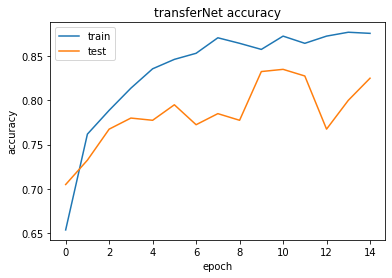

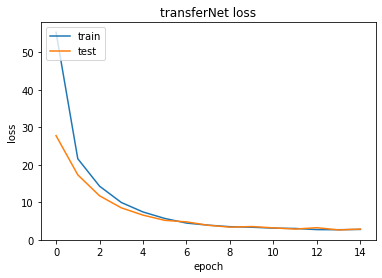

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history,name):

    # summarize history for accuracy
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title(name + ' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title(name + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    

name="transferNet"
#metrics_hists = history_transfer.history

plot_history(metrics_hists, name)


In [ ]:
#Ale Images Predictor
datadir = '/content/drive/My Drive/datasets/saad_dataset/'

batch_size = 10


datagen = ImageDataGenerator(
    rescale = 1. / 255
    )
val_generator = datagen.flow_from_directory(
    directory=datadir,
    class_mode=None,
    target_size=(227, 227),
    color_mode="rgb",
    batch_size=batch_size,
    shuffle=False,
)

val_steps=val_generator.n//val_generator.batch_size+1


val_generator.reset()
preds = transfer_model.predict_generator(val_generator,verbose=1,steps=val_steps)
Ypred = np.argmax(preds, axis=1)

Found 10 images belonging to 1 classes.
2/2 [==============================] - 7s 4s/step


HAZE


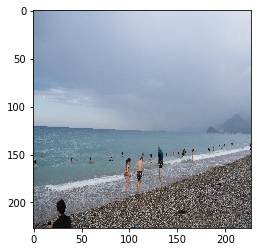

HAZE


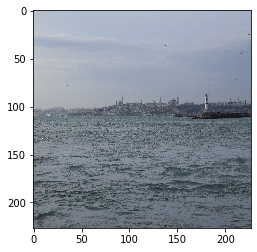

SUNNY


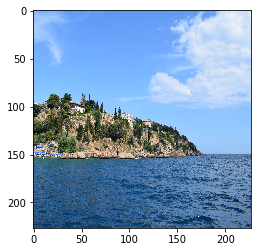

SUNNY


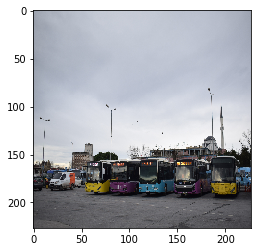

SUNNY


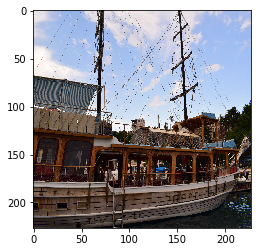

SUNNY


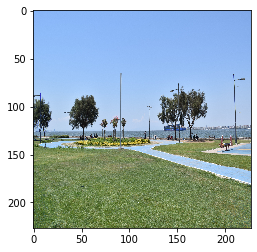

SUNNY


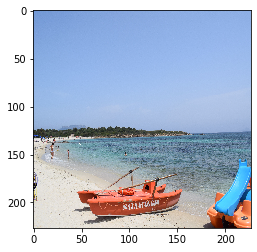

SUNNY


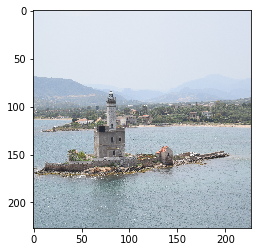

HAZE


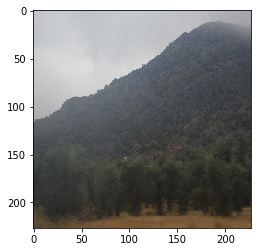

SUNNY


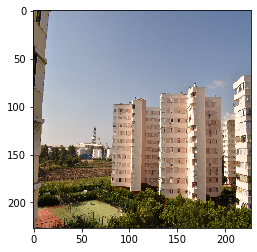

In [ ]:
val_generator.reset()
x = val_generator.next()
# x,y size is train_generator.batch_size
for i in range(0,10):
  image_num = i
  image = x[image_num]
  plt.imshow(image)
  print(classnames[Ypred[image_num]])
  plt.show()


In [ ]:
#Blind Test Labeling

blind_directory = '/content/drive/My Drive/datasets/WeatherBlindTestSet/'

batch_size = 100

blind_datagen = ImageDataGenerator(
    rescale = 1. / 255
    )
blind_generator = blind_datagen.flow_from_directory(
    directory=blind_directory,
    class_mode=None,
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    shuffle=False,
)



Found 1500 images belonging to 1 classes.


In [ ]:
val_steps=blind_generator.n//blind_generator.batch_size

preds = transfer_model.predict_generator(blind_generator,verbose=1,steps=val_steps)
Ypred = np.argmax(preds, axis=1)

 5/15 [=========>....................] - ETA: 3:02

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 5 could not be retrieved. It could be because a worker has died.
  UserWarning)


13/15 [=========================>....] - ETA: 50s 

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 13 could not be retrieved. It could be because a worker has died.
  UserWarning)


15/15 [==============================] - 387s 26s/step


In [ ]:
len(Ypred)

100

In [ ]:
blind_generator.reset()
x = blind_generator.next()
# x,y size is train_generator.batch_size
for i in range(0,10):
  image_num = i
  image = x[image_num]
  plt.imshow(image)
  print(classnames[Ypred[image_num]])
  plt.show()


In [ ]:
blind_test_results = [[classnames[Ypred[i]]] for i in range(0,1500)]


In [ ]:
print(blind_test_results[3])

['RAINY']


In [ ]:
import csv
with open('/content/drive/My Drive/datasets/1853356.csv', 'w') as writeFile:
    writer = csv.writer(writeFile) 
    writer.writerows(blind_test_results)
writeFile.close()